In [65]:
import numpy as np
import nibabel as nbl
import os
import glob
import scipy.stats as pysts
import itertools as itr
from matplotlib import pyplot as plt
from nilearn import plotting

In [115]:
base_dir='/mnt/datashare/Pr1.LL/Analysis/Analysis_level2/uniVar_opEv[Final]/'
os.chdir(base_dir)

#load pull affines/header info from the files as we load them into array
dats=[nbl.load(base_dir+nii_file) for nii_file in glob.glob('*/*006.nii')]

#save affine and header for writing nii's later
affines=dats[0].affine
heads=dats[0].header

dats=np.array([d.get_data() for d in dats])

#this function need to be fixed later to pull out spherical ROI
'''
def sphere(origin=(0,0,0), radius=1, precision=.1):
    
    #hidden functions for each of coodrinate transfromation
    def x_trans(x, r, theta, phi):
        return(x+(r*np.sin(phi)*np.cos(theta)))

    def y_trans(y, r, theta, phi):
        return(y+(r*np.sin(phi)*np.sin(theta)))
    
    def z_trans(z, r, phi):
        return(z+(r*np.cos(phi)))
    
    
    #create 2d array of radians for theta and phi
    tp=itr.permutations(np.arange(0,2, precision), np.arange(0,2, precision))
    
    #map to 3 tuples
 '''   
    
    
def box_mask(origin=(0, 0, 0), shape=(79, 95, 79), length=10, precision=1):
    
    mask=np.zeros(shape)
    
    #create all the indexes for the maksing part
    x_vec=np.arange(origin[0]-length, origin[0]+length, precision)
    y_vec=np.arange(origin[1]-length, origin[1]+length, precision)
    z_vec=np.arange(origin[2]-length, origin[2]+length, precision)
    mask_cors=itr.permutations(x_vec, y_vec, z_vec)

    mask[mask_cors]=1
    
    return mask

def random_narray(data):
    #randomly permute an array along 3d axes since
    #so we can randomize voxels
    x_axis=np.random.permutation(range(data.shape[0]))
    y_axis=np.random.permutation(range(data.shape[1]))
    z_axis=np.random.permutation(range(data.shape[2]))
    
    x, y, z=np.meshgrid(x_axis, y_axis, z_axis)
    
    
    #reshape the gird back to form for consitency
    return np.swapaxes(data[x, y, z], 0, 1)
    

def boot_fmri(fmri_data, permutes=100, write=False, ROI=None):
    
    
    if ROI:
        roi=box_mask(origin=ROI['origin'], shape=data.shape, length=ROI['size'])
        fmri_data=np.array([fmri_data[i, :, :, :] * roi for i in range(fmri_data.shape[0])])
        
        #keep only the non-zero elements across subjects
        fmri_data=fmri_data[np.nonzero(fmri_data)]
    
    
    #pull the distribution of t-stats across subjects
    true_t=pysts.ttest_1samp(fmri_data, popmean=0, axis=0, nan_policy='omit')[0]
    
    #make empty array for permutation tests for faster assignement
    t_array=np.empty((permutes, fmri_data.shape[1], fmri_data.shape[2], fmri_data.shape[3]))
    for k in range(permutes):
       
        rand_array=np.array([random_narray(fmri_data[j, :, :, :]) for j in range(fmri_data.shape[0])])
        
        t_array[k, :, :, :]=pysts.ttest_1samp(rand_array, popmean=0, axis=0, nan_policy='omit')[0]
             
    
    #final test for proportion of values greater than
    perm_test=np.array([np.greater(true_t, t_array[f]) for f in range(t_array.shape[0])])
    perm_test=np.sum(perm_test, axis=0)/permutes
    
    return{'boot_test': perm_test, 'boot_array':t_array, 'true_data': true_t}
        
    



In [90]:
boot_data=boot_fmri(dats, permutes=500)

/home/local/AD3/ppwitkow/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/local/AD3/ppwitkow/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/local/AD3/ppwitkow/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/local/AD3/ppwitkow/.local/lib/python3.5/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater


These plots look at the distribution of t-statitics from the permuted data and the distribution of p-values for the comparision between the real t-tests and permuted t-tests. The distribution of t-statistics will tell us if the permutations were done correctly since the should be t-distributed around 0. The p-value disrtirubtion will tell us if our data are biased towards higher values. 

Text(0.5,0,'T Scores')

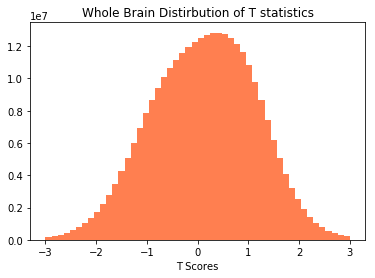

In [91]:
t_hist=plt.hist(boot_data['boot_array'].flatten(), facecolor='coral', bins=50, range=[-3, 3])
plt.title('Whole Brain Distirbution of T statistics')
plt.xlabel('T Scores')

Text(0.5,0,'Proportion of Randomly Generated T-Stats Higher Than Observed')

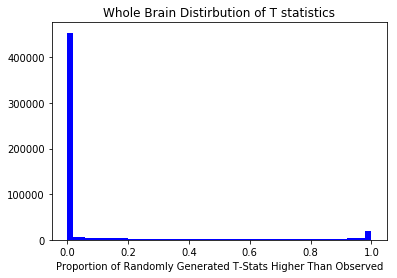

In [92]:
#look at the distribution of proportions
t_hist=plt.hist(boot_data['boot_test'].flatten(), facecolor='blue', bins=50, range=[0, 1])
plt.title('Whole Brain Distirbution of T statistics')
plt.xlabel('Proportion of Randomly Generated T-Stats Higher Than Observed')

In [122]:
#save the arrays as nifti images for viewing and reference
td=nbl.Nifti1Image(boot_data['boot_test'], affines, heads)
td.to_filename(os.path.join('/mnt/datashare/Pr1.LL/Python Tools and Code', 'DKL_t-stat.nii'))

boot_test=nbl.Nifti1Image(boot_data['boot_test'],  affines, heads)
boot_test.to_filename((os.path.join('/mnt/datashare/Pr1.LL/Python Tools and Code', 'boot DKl t-stat.nii')))

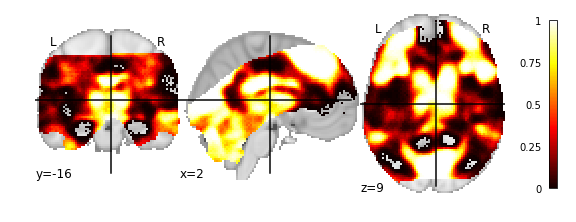

In [123]:
plotting.plot_stat_map((os.path.join('/mnt/datashare/Pr1.LL/Python Tools and Code', 'DKL_t-stat.nii')))

array([[  -2.,    0.,    0.,   78.],
       [   0.,    2.,    0., -112.],
       [   0.,    0.,    2.,  -70.],
       [   0.,    0.,    0.,    1.]])